In [ ]:
# !pip install statsmodels

  Using cached statsmodels-0.14.5-cp313-cp313-win_amd64.whl.metadata (9.8 kB)
Using cached statsmodels-0.14.5-cp313-cp313-win_amd64.whl (9.6 MB)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('F1_main_data_v8.csv')
print("shape:", df.shape)
display(df.head())
display(pd.DataFrame({'dtype': df.dtypes, 'missing': df.isna().sum()}).sort_values('missing', ascending=False))


FileNotFoundError: [Errno 2] No such file or directory: 'F1_main_data_v8.csv'

In [21]:
# preferred finish columns to check
finish_candidates = [c for c in df.columns if any(k in c.lower() for k in ['finish','finishing','position','result','place'])]
print("finish candidates:", finish_candidates)

# example logic:
if 'FinishPosition' in df.columns:
    df['win_flag'] = (df['FinishPosition'] == 1).astype(int)
elif 'RacePosition' in df.columns:
    df['win_flag'] = (df['RacePosition'] == 1).astype(int)
else:
    # fallback: if race_id + points exist, derive per-race winner
    if any('race' in c.lower() for c in df.columns) and any('point' in c.lower() for c in df.columns):
        race_col = [c for c in df.columns if 'race' in c.lower()][0]
        pts_col = [c for c in df.columns if 'point' in c.lower()][0]
        df['_max_pts'] = df.groupby(race_col)[pts_col].transform('max')
        df['win_flag'] = (df[pts_col] == df['_max_pts']).astype(int)
    else:
        # last resort: use QualifyingPosition == 1 as proxy
        if 'QualifyingPosition' in df.columns:
            df['win_flag'] = (df['QualifyingPosition'] == 1).astype(int)
        else:
            raise ValueError("No finish/points/qualifying columns found — please tell me which column indicates finishing position")

finish candidates: ['QualifyingPosition', 'RaceFinishPosition', 'Finish', 'Finish_pct']


In [22]:
# show columns with >10% missing
missing = df.isna().mean().sort_values(ascending=False)
display(missing[missing > 0.10])

# convert obvious numerics
for c in df.columns:
    if df[c].dtype == 'object':
        try:
            df[c] = pd.to_numeric(df[c].str.replace(',',''), errors='raise')
        except Exception:
            pass

# simple imputation for modeling-ready numeric table
numeric = df.select_dtypes(include=['number']).copy()
numeric = numeric.fillna(numeric.median())

Series([], dtype: float64)

In [23]:
driver_kw = ['driver','qualif','qualify','grid','experience','age','errors','mistake','stint','overtake','laps_led']
car_kw = ['constructor','team','engine','pit','tire','reliab','horse','hp','aero','setup','chassis','brake','weight','top_speed']
race_kw = ['track','circuit','weather','rain','temp','round','race','lap_length','laps']

driver_features = [c for c in df.columns if any(k in c.lower() for k in driver_kw)]
car_features = [c for c in df.columns if any(k in c.lower() for k in car_kw)]
race_features = [c for c in df.columns if any(k in c.lower() for k in race_kw)]

print("driver_features:", driver_features)
print("car_features:", car_features)
print("race_features:", race_features)

driver_features: ['driver_code', 'QualifyingPosition', 'driver_points', 'Damage Related', 'Damage Related_pct']
car_features: ['RaceFinishPosition', 'team', 'team_points']
race_features: ['Consistency_Race', 'Style_Race', 'Technical_Race', 'Pace_Race', 'PerformanceIndex_Race', 'Round', 'RaceFinishPosition', 'Laps', 'Circuit length (km)', 'Race distance (km)', 'Race_Complexity_Score']


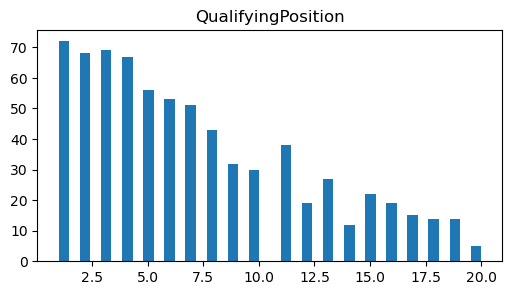

In [24]:
import matplotlib.pyplot as plt

cols_to_plot = ['QualifyingPosition','BestLapTime','AvgSpeed','num_incidents','pit_stop_time','engine_power']
for c in cols_to_plot:
    if c in df.columns:
        plt.figure(figsize=(6,3))
        plt.hist(df[c].dropna(), bins=40)
        plt.title(c)
        plt.show()

win_flag                 1.000000
Pace_Race                0.297626
PerformanceIndex_Race    0.112132
Pace_Qual                0.079765
driver_points            0.071997
team_points              0.049561
Consistency_Race         0.043291
Technical_Race           0.042379
Corners                  0.034267
year                     0.031171
Style_Qual               0.024113
Collision_pct            0.021477
Laps                     0.020579
PerformanceIndex_Qual    0.020117
Race_Complexity_Score    0.014270
DNF_pct                  0.001553
Finish_pct              -0.001553
Collision               -0.009554
Safety_Index            -0.010661
Consistency_Qual        -0.012944
dtype: float64

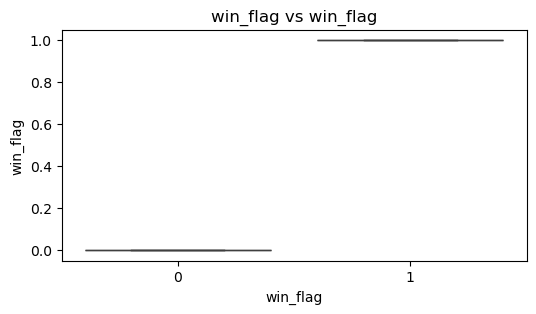

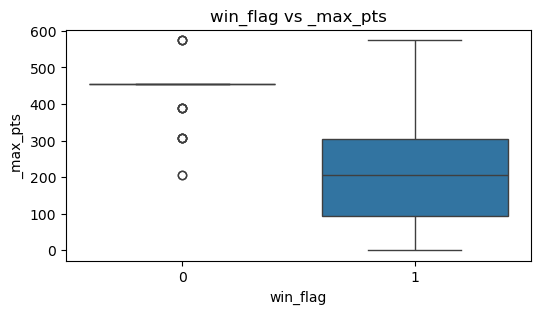

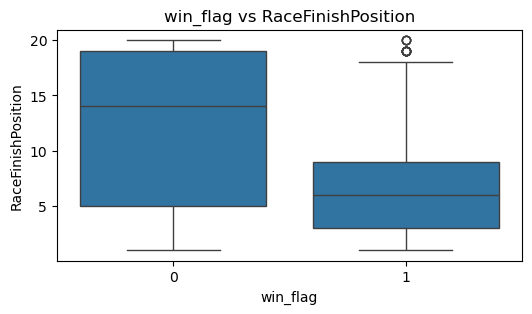

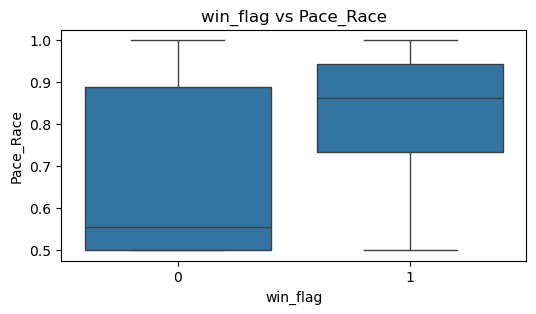

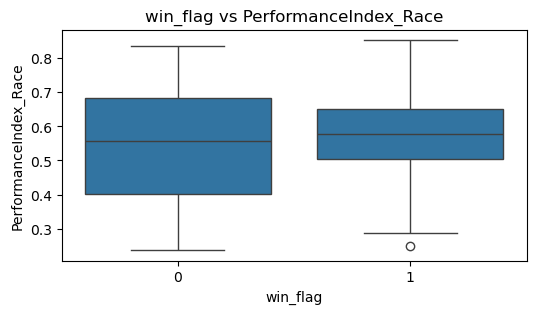

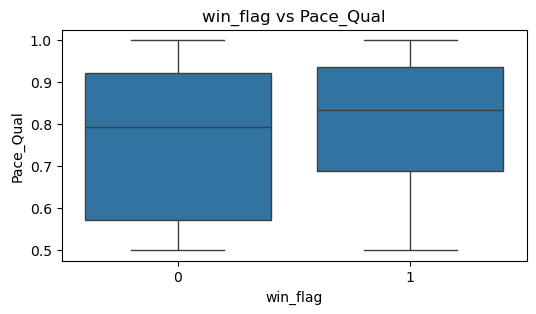

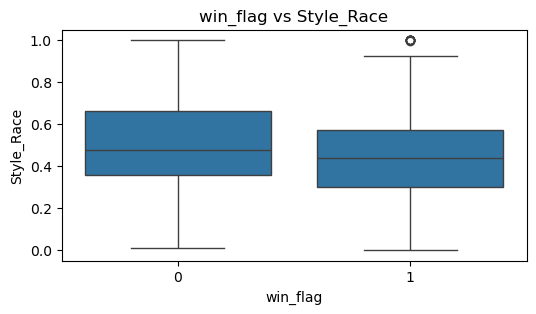

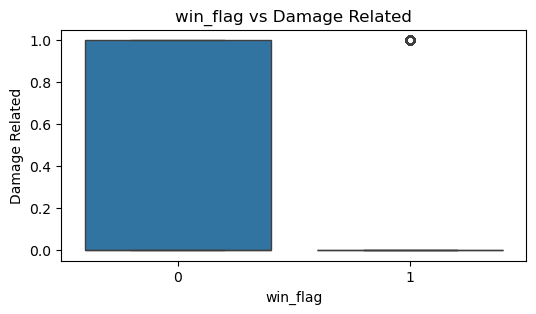

In [25]:
# numeric correlations (point-biserial style)
num = df.select_dtypes(include=['number'])
corrs = num.corrwith(df['win_flag']).sort_values(ascending=False)
display(corrs.head(20))

# boxplots for top numeric correlates
top_feats = corrs.abs().sort_values(ascending=False).head(8).index.tolist()
import seaborn as sns
for f in top_feats:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df['win_flag'], y=df[f])
    plt.title(f'win_flag vs {f}')
    plt.show()

In [26]:
# win rate by driver
if 'DriverName' in df.columns:
    drv = df.groupby('DriverName')['win_flag'].agg(['sum','count'])
    drv['win_rate'] = drv['sum'] / drv['count']
    display(drv.sort_values('win_rate', ascending=False).head(20))

# win rate by constructor/team
team_col = [c for c in df.columns if any(k in c.lower() for k in ['constructor','team'])]
if team_col:
    team = df.groupby(team_col[0])['win_flag'].agg(['sum','count'])
    team['win_rate'] = team['sum'] / team['count']
    display(team.sort_values('win_rate', ascending=False).head(20))

# qualifying band effect
if 'QualifyingPosition' in df.columns:
    df['qual_bin'] = pd.cut(df['QualifyingPosition'], bins=[0,1,3,6,10,20,100], labels=['P1','P2-3','P4-6','P7-10','P11-20','P21+'])
    display(df.groupby('qual_bin')['win_flag'].mean())

,sum,count,win_rate
team,,,
Red Bull Racing,18,18,1.000000
Aston Martin Aramco Mercedes,31,32,0.968750
Renault,13,14,0.928571
Red Bull Racing RBPT,24,26,0.923077
Red Bull Racing Honda RBPT,58,64,0.906250
Mercedes,110,123,0.894309
Ferrari,129,149,0.865772
McLaren,31,36,0.861111
McLaren Renault,12,14,0.857143


/var/folders/c2/r8gn4nb938xflq6bbqlygjxc0000gn/T/ipykernel_2256/1182642945.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby('qual_bin')['win_flag'].mean())


qual_bin
P1        0.902778
P2-3      0.846715
P4-6      0.886364
P7-10     0.891026
P11-20    0.816216
P21+           NaN
Name: win_flag, dtype: float64

In [27]:
# example: qualifying_gap = qualifying_time - best_qualifying_time_on_grid
if 'QualifyingTime' in df.columns and 'Grid' in df.columns and 'RaceId' in df.columns:
    df['qual_min'] = df.groupby('RaceId')['QualifyingTime'].transform('min')
    df['qual_gap'] = df['QualifyingTime'] - df['qual_min']

# reliability score: 1 if car finished race (no DNF), 0 if DNF
if 'Status' in df.columns:
    df['finished'] = df['Status'].apply(lambda s: 0 if 'ret' in str(s).lower() or 'dnf' in str(s).lower() else 1)

# team_strength: historical average points per race by constructor (over dataset)
if team_col:
    team_pts_col = [c for c in df.columns if 'points' in c.lower()]
    if team_pts_col:
        team_strength = df.groupby(team_col[0])[team_pts_col[0]].mean()
        df['team_strength'] = df[team_col[0]].map(team_strength)


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

def run_model(X_df, y, label):
    X = X_df.fillna(X_df.median())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:,1]
    return {'label': label,
            'accuracy': accuracy_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_proba),
            'importances': pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)}

# prepare Xs
driver_X = df[driver_features].select_dtypes(include=['number']).copy()
car_X = df[car_features].select_dtypes(include=['number']).copy()
combined_X = pd.concat([driver_X, car_X], axis=1)

res_driver = run_model(driver_X, df['win_flag'], 'driver_only')
res_car = run_model(car_X, df['win_flag'], 'car_only')
res_combined = run_model(combined_X, df['win_flag'], 'combined')

print(res_driver['label'], res_driver['accuracy'], res_driver['auc'])
print(res_car['label'], res_car['accuracy'], res_car['auc'])
print(res_combined['label'], res_combined['accuracy'], res_combined['auc'])

driver_only 0.7417582417582418 0.5081528662420383
car_only 0.7527472527472527 0.7438216560509554
combined 0.8296703296703297 0.6982165605095542


In [29]:
from scipy.stats import ttest_ind, chi2_contingency

# t-test example
feat = 'QualifyingPosition'
winners = df[df['win_flag'] == 1][feat].dropna()
losers = df[df['win_flag'] == 0][feat].dropna()
tt = ttest_ind(winners, losers, equal_var=False)
print(feat, "t-stat:", tt.statistic, "p:", tt.pvalue)

# chi-square example for categorical tyre
if 'TireCompound' in df.columns:
    ct = pd.crosstab(df['TireCompound'], df['win_flag'])
    chi2, p, dof, exp = chi2_contingency(ct)
    print("TireCompound chi2 p:", p)

QualifyingPosition t-stat: -1.7751732077223459 p: 0.07830288379002814



Driver variables detected: ['driver_code', 'QualifyingPosition', 'driver_points', 'Laps']
Car variables detected: ['team', 'team_points', 'team_strength']

=== DRIVER PERFORMANCE COMPARISON: Winners vs Non-winners ===
driver_code: skipped (unsupported operand type(s) for /: 'str' and 'int')
QualifyingPosition: t = -1.78, p = 0.0783
driver_points: t = 2.09, p = 0.0389
Laps: t = 0.51, p = 0.6131

=== LOGISTIC REGRESSION: Probability of Winning ===
                           Logit Regression Results                           
Dep. Variable:               win_flag   No. Observations:                  726
Model:                          Logit   Df Residuals:                      721
Method:                           MLE   Df Model:                            4
Date:                Wed, 12 Nov 2025   Pseudo R-squ.:                 0.01027
Time:                        20:21:28   Log-Likelihood:                -286.20
converged:                       True   LL-Null:                       -289

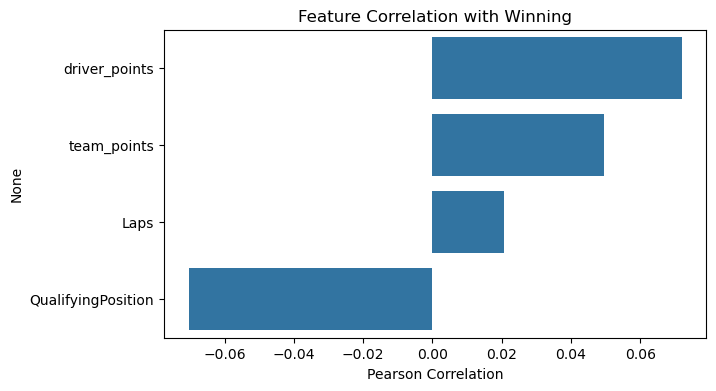

In [30]:
# --- 4️⃣ Select Potential Predictors ---
driver_vars = [c for c in df.columns if any(k in c.lower() for k in ['qualifying','driver','lap','experience','skill'])]
car_vars = [c for c in df.columns if any(k in c.lower() for k in ['engine','car','constructor','team','pit','chassis','aero','power'])]
print("\nDriver variables detected:", driver_vars)
print("Car variables detected:", car_vars)

# --- 5️⃣ Independent Samples t-Test (Driver Factors) ---
print("\n=== DRIVER PERFORMANCE COMPARISON: Winners vs Non-winners ===")
for var in driver_vars:
    try:
        win_group = df[df['win_flag'] == 1][var].dropna()
        lose_group = df[df['win_flag'] == 0][var].dropna()
        if len(win_group) > 1 and len(lose_group) > 1:
            t, p = ttest_ind(win_group, lose_group, equal_var=False)
            print(f"{var}: t = {t:.2f}, p = {p:.4f}")
    except Exception as e:
        print(f"{var}: skipped ({e})")

# --- 6️⃣ ANOVA (Team / Constructor Effects) ---
if any(c.lower() == 'constructor' for c in df.columns):
    print("\n=== TEAM EFFECT ON FINISHING POSITION (ANOVA) ===")
    finish_col = finish_candidates[0] if finish_candidates else None
    if finish_col:
        model = smf.ols(f"{finish_col} ~ C(Constructor)", data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(anova_table)

        plt.figure(figsize=(10,5))
        sns.barplot(x='Constructor', y=finish_col, data=df, ci='sd')
        plt.title("Average Finishing Position per Team")
        plt.xticks(rotation=45)
        plt.show()

# --- 7️⃣ Logistic Regression (Combined Influence) ---
print("\n=== LOGISTIC REGRESSION: Probability of Winning ===")

# Keep only numeric features
num_features = df[features].select_dtypes(include=[np.number]).columns.tolist()

# Ensure no all-NaN columns
num_features = [f for f in num_features if df[f].notnull().sum() > 0]

if not num_features:
    raise ValueError("No numeric features found for logistic regression — check your dataset or feature list.")

X = df[num_features].fillna(df[num_features].median())
X = sm.add_constant(X)
y = df['win_flag']

# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit(disp=False)

print(result.summary())

# --- 8️⃣ Correlation Analysis ---
print("\n=== CORRELATION WITH WINNING (Pearson) ===")
corrs = {}
for col in features:
    try:
        corrs[col], _ = pearsonr(df[col].dropna(), df['win_flag'].loc[df[col].notnull()])
    except:
        pass

corr_series = pd.Series(corrs).sort_values(ascending=False)
print(corr_series.head(10))

plt.figure(figsize=(7,4))
sns.barplot(x=corr_series.values, y=corr_series.index)
plt.title("Feature Correlation with Winning")
plt.xlabel("Pearson Correlation")
plt.show()